In [1]:

import numpy as np
from scipy.linalg import cho_solve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib
from scipy.linalg import cho_solve
import pandas as pd
from scipy.optimize import fmin_cobyla
from sklearn.preprocessing import MinMaxScaler

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Physics-constrained GP EOS model

Let $\mathbf{X}_{1} = \left\{(V_1^{(i)}, T_1^{(i)})\right\}_{i=1}^{n_1}$ and $\mathbf{X}_{2} = \left\{(V_2^{(i)}, T_2^{(i)})\right\}_{i=1}^{n_2}$ represent the input points, where $V$ and $T$ denote volume and temperature, respectively. The corresponding outputs for the equations of state (EOS) are given as pressure $y_1 = \left\{P^{(i)}\right\}_{i=1}^{n_1}$ and energy $y_2 = \left\{E^{(i)}\right\}_{i=1}^{n_2}$, respectively.

We assume a GP prior for the Helmholtz free energy as

$F \sim G P\left[\mu_F(\mathbf{X}), k_{F F}\left(\mathbf{X}, \mathbf{X}^{\prime}\right)\right]$ 

The relationship between Helmholtz free energy (F) and the EOS outputs (P and E) given as,

$\begin{gathered}P=-\left.\frac{\partial F}{\partial V}\right|_T \\ E=F-\left.T \frac{\partial F}{\partial T}\right|_V\end{gathered}$

Using this relationship, we can write the joint prior for the pressure and energy GP as,

$\left.\left[\begin{array}{l}P \\ E\end{array}\right] \right\rvert\, \mathbf{X} \sim G P\left[\mathscr{L}_{\mathbf{X}} \mu_F(\mathbf{X}), \mathscr{L}_{\mathbf{X}} k_{F F}\left(\mathbf{X}, \mathbf{X}^{\prime}\right) \mathscr{L}_{\mathbf{X}^{\prime}}^T\right]$

where 

$\mathscr{L}_{\mathbf{X}}=\binom{-\frac{\partial}{\partial V}}{1-T \frac{\partial}{\partial T}}$.

Expanding it, we get,

$\left[\begin{array}{l}P \\ E\end{array}\right] \left\lvert\, \mathbf{X}_{1}, \mathbf{X}_{2} \sim G P\left(\left[\begin{array}{c}\frac{\partial \mu_F(\mathbf{X}_{1})}{\partial V} \\ \mu_F-T \frac{\partial \mu_F(\mathbf{X}_{2})}{\partial T}\end{array}\right],\left[\begin{array}{cc}\frac{\partial}{\partial V} \frac{\partial}{\partial V^{\prime}} k_{F F}\left(\mathbf{X}_{1}, \mathbf{X}_{2}\right) & -\frac{\partial}{\partial V}\left(1-T^{\prime} \frac{\partial}{\partial T^{\prime}}\right) k_{F F}\left(\mathbf{X}_{1}, \mathbf{X}_{2}\right) \\ -\frac{\partial}{\partial V^{\prime}}\left(1-T \frac{\partial}{\partial T}\right) k_{F F}\left(\mathbf{X}_{2}, \mathbf{X}_{1}\right) & \left(1-T \frac{\partial}{\partial T}\right)\left(1-T^{\prime} \frac{\partial}{\partial T^{\prime}}\right) k_{F F}\left(\mathbf{X}_{2}, \mathbf{X}_{2}\right)\end{array}\right]\right)\right.$

Rewriting this for notational simplicity, we have:

$\left[\begin{array}{l}P \\ E\end{array}\right] \left\lvert\, \mathbf{X_1}, \mathbf{X_1} \sim G P\left(\left[\begin{array}{l}\mu_P(\mathbf{X}_{1}) \\ \mu_E(\mathbf{X}_{2})\end{array}\right],\left[\begin{array}{ll}K_{P P}(\mathbf{X}_{1}, \mathbf{X}_{1}) & K_{P E}(\mathbf{X}_{1}, \mathbf{X}_{2}) \\ K_{E P}(\mathbf{X}_{2}, \mathbf{X}_{1}) & K_{E E}(\mathbf{X}_{2}, \mathbf{X}_{2})\end{array}\right]\right)\right.$


The following function represents the kernel used in this joint Gaussian process (GP) prior, derived from the squared-exponential kernel for free energy. To customize this, you can replace the function with your own manually derived kernel functions based on the choice of covariance model for free energy.


In [2]:
def kernel(x1, x2, l1, l2, sigma_f, sigma_n1, sigma_n2):
    
    """
    This function computes the kernel matrix for a given set of input data points (volume,temperature).
    
    Parameters:
    x1 (numpy array): Input data points for the pressure.
    x2 (numpy array): Input data points for the energy.
    l1 (float): Length scale for the first dimension i.e., volume.
    l2 (float): Length scale for the second dimension i.e., temperature.
    sigma_f (float): Signal variance.
    sigma_n1 (float): Noise variance for the pressure data.
    sigma_n2 (float): Noise variance for the energy data.
    
    Returns:
    K_PP (numpy array): Kernel matrix for the pressure.
    K_PE (numpy array): Kernel matrix for the cross-covariance between the pressure and energy.
    K_EP (numpy array): Kernel matrix for the cross-covariance between the energy and pressure.
    K_EE (numpy array): Kernel matrix for the energy.
    """
    
    theta = np.array([1/(2*l1**2), 1/(2*l2**2)])
    diff_x = x1[:, None, :] - x2[None, :, :]
    sq_diff_x = diff_x ** 2
    exp_term = np.exp(-np.sum(theta * sq_diff_x, axis=2))

    K_PP = sigma_f**2 * exp_term * (2*theta[0] - 4*theta[0]**2 * sq_diff_x[:,:,0]) + np.eye(x1.shape[0],x2.shape[0]) * (sigma_n1)**2
    
    K_PE = sigma_f**2 * (exp_term * (2 * theta[0] * (x1[:, 0][:, None] - x2[:, 0][None, :])) -
                      x2[:, 1][None, :] * exp_term * (4 * theta[0] * theta[1] * (x1[:, 0][:, None] - x2[:, 0][None, :]) * (x1[:, 1][:, None] - x2[:, 1][None, :])))
    
    K_EP = sigma_f**2 * (exp_term * (2 * theta[0] * (-x1[:, 0][:, None] + x2[:, 0][None, :])) -
                      x1[:, 1][:, None] * np.exp(-np.sum(theta * sq_diff_x, axis=2)) * (4 * theta[0] * theta[1] * (x1[:, 0][:, None] - x2[:, 0][None, :]) * (x1[:, 1][:, None] - x2[:, 1][None, :])))
    
    K_EE = sigma_f**2 * (exp_term +
                      x1[:, 1][:, None] * exp_term * (2 * theta[1] * (x1[:, 1][:, None] - x2[:, 1][None, :])) +
                      x2[:, 1][None, :] * exp_term * (2 * theta[1] * (-x1[:, 1][:, None] + x2[:, 1][None, :])) +
                      x1[:, 1][:, None] * x2[:, 1][None, :] * exp_term * (2 * theta[1] - 4 * theta[1]**2 * sq_diff_x[:,:,1])) + np.eye(x1.shape[0],x2.shape[0]) * (sigma_n2)**2
    

    return K_PP, K_PE, K_EP, K_EE

The joint GP EOS is subject to the following thermodynamic stability constraints:

$\begin{aligned} & \mathbb{P}\left[\left(\left.\frac{\partial P\left(\mathbf{X}_v\right)}{\partial V} \right\rvert\, \mathbf{X}_v, P, \mathbf{X}\right)>0\right] \leq \eta \\ & \mathbb{P}\left[\left(\left.\frac{\partial E\left(\mathbf{X}_v\right)}{\partial T} \right\rvert\, \mathbf{X}_v, E, \mathbf{X}\right)<0\right] \leq \eta\end{aligned}$

To enforce these constraints, we need to compute the joint derivative GPs i.e.,
$\left.\left[\begin{array}{l}\partial P/\partial V \\ \partial E/\partial T\end{array}\right] \right\rvert\, \mathbf{X} \sim G P\left[\mathcal{L}_{\mathbf{X}} \left[\begin{array}{l}\mu_P(\mathbf{X}) \\ \mu_E(\mathbf{X}) \end{array}\right], \mathcal{L}_{\mathbf{X}} \mathbf{K}\left(\mathbf{X}, \mathbf{X}^{\prime}\right) \mathcal{L}_{\mathbf{X}^{\prime}}^T\right]$

The following function computes the kernel function for the given joint derivative GP:

In [3]:
def kernel_prime(x1, x2, l1, l2, sigma_f, sigma_n1, sigma_n2):
    
    """
    This function computes the kernel matrix for the derivate GP [dP/dV, dE/dT] given set of input data points.
    
    Parameters:
    x1 (numpy array): Input data points (volume,temperature) for the dP/dV.
    x2 (numpy array): Input data points (volume,temperature) for the dE/dT.
    l1 (float): Length scale for the first dimension i.e., volume.
    l2 (float): Length scale for the second dimension i.e., temperature.
    sigma_f (float): Signal variance.
    sigma_n1 (float): Noise variance for the pressure data.
    sigma_n2 (float): Noise variance for the energy data.
    
    Returns:
    K_PP_prime (numpy array): Kernel matrix for the dP/dV.
    K_PE_prime (numpy array): Kernel matrix for the cross-covariance between the dP/dV and dE/dT.
    K_EP_prime (numpy array): Kernel matrix for the cross-covariance between the dE/dT and dP/dV.
    K_EE_prime (numpy array): Kernel matrix for the dE/dT.
    """
    
    theta = np.array([1/(2*l1**2), 1/(2*l2**2)])

    diff_x = x1[:, None, :] - x2[None, :, :]
    sq_diff_x = diff_x ** 2
    exp_term = np.exp(-np.sum(theta * sq_diff_x, axis=2))

    K_PP_prime = sigma_f**2 * exp_term * (4 * theta[0]**2 * (-8 * theta[0] * sq_diff_x[:,:,0] + (2 * theta[0] * sq_diff_x[:,:,0] - 1)**2 + 2)) + np.eye(x1.shape[0],x2.shape[0]) * (sigma_n1)**2
    K_PE_prime = sigma_f**2 * exp_term * (4 * x2[:, 1][None, :] * theta[0] * theta[1] * (2 * theta[0] * sq_diff_x[:,:,0] - 1) * (2 * theta[1] * sq_diff_x[:,:,1] - 1))
    K_EP_prime = sigma_f**2 * exp_term * (4 * x1[:, 1][:, None] * theta[0] * theta[1] * (2 * theta[0] * sq_diff_x[:,:,0] - 1) * (2 * theta[1] * sq_diff_x[:,:,1] - 1))
    K_EE_prime = sigma_f**2 * exp_term * (4 * x1[:, 1][:, None] * x2[:, 1][None, :] * theta[1]**2 * (-8 * theta[1] * sq_diff_x[:,:,1] + (2 * theta[1] * sq_diff_x[:,:,1] - 1)**2 + 2)) + np.eye(x1.shape[0],x2.shape[0]) * (sigma_n2)**2

    
    return K_PP_prime, K_PE_prime, K_EP_prime, K_EE_prime

The following class implements the joint Gaussian process EOS with the specified constraints. It needs to be instantiated with the kernel and kernel_prime functions which is user-defined based on the given problem. The optional arguments represents the noise level and whether the constraints should be enforced.

**Note**: The proper modeling of the mean functions are essential for the convergence of the GP. In this code, a polynomial regression mean function of degree 3 is used for each of pressure and energy, respectively.

In [4]:
class GP_EOS:
    def __init__(self, kernel, kernel_prime, noise=1e-10, constraints=True):
        
        """
        Initialize a Gaussian Process EOS model with the given kernel and kernel_prime functions.
    
        Parameters:
        kernel (function): The kernel function used for the joint Gaussian process. It takes in the input data, hyperparameters, and returns the covariance matrix.
        kernel_prime (function): The kernel function used for the joint Gaussian process of the derivatives. It takes in the input data, hyperparameters, and returns the covariance matrix.
        noise (float, optional): The noise level added to the diagonal of the covariance matrix. Default is 1e-10.
        constraints (bool, optional): A flag indicating whether to enforce the thermodynamic constraints. Default is True.
        
        """
        self.kernel = kernel
        self.kernel_prime = kernel_prime
        self.noise = noise
        self.constraints = constraints

        
    def test_points(self, n_test, constant_V=True):
        
        """
        Generate a set of test points for the GP EOS model.

        Parameters:
        n_test (int): The number of test points to generate in each dimension.
        constant_V (bool, optional): A flag indicating whether the test points should have a constant volume. Default is True. This is useful when taking gradient based on a fixed dimension.

        Returns:
        np.ndarray: A 2D array containing the test points. Each row represents a test point with coordinates (V, T) with dimensions (n_test*n_test, 2).
        """
        V = np.linspace(0, 1, n_test)
        T = np.linspace(0, 1, n_test)

        if constant_V:
            return np.column_stack((np.repeat(V, len(T)), np.tile(T, len(V))))  
        else:
            return np.column_stack((np.tile(V, len(T)), np.repeat(T, len(V))))
        
    def fit(self, x1, x2, y1, y2):
        
        """
        Fit the GP EOS model with the given data.

        Parameters:
        x1 (numpy.ndarray): Input data for pressure with shape (n1, 2), where n1 is the number of data points.
        x2 (numpy.ndarray): Input data for energy with shape (n2, 2), where n2 is the number of data points.
        y1 (numpy.ndarray): Pressure values with shape (n1,1).
        y2 (numpy.ndarray): Energy with shape (n2,1).

        Returns:
        numpy.ndarray: The optimized hyperparameters.
        """
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.optimize_hyperparameters()
        return self.theta

    def poly_regression_mean(self, x_test1, x_test2, degree=3):
        
        """
        This function performs polynomial regression on the input data to generate mean functions for the GP EOS model.

        Parameters:
        x_test1 (numpy.ndarray): Input test data for pressure with shape (n1, 2), where n1 is the number of data points.
        x_test2 (numpy.ndarray): Input test data for energy with shape (n2, 2), where n2 is the number of data points.
        degree (int, optional): Degree of the polynomial features. Default is 3.

        Returns:
        mu1 (numpy.ndarray): Mean values for pressure with shape (n1, 1).
        mu2 (numpy.ndarray): Mean values for energy with shape (n2, 1).
        mu_test1 (numpy.ndarray): Mean values for pressure at test points with shape (n1, 1).
        mu_test2 (numpy.ndarray): Mean values for energy at test points with shape (n2, 1).
        """
        poly = PolynomialFeatures(degree)

        poly_train1 = poly.fit_transform(self.x1)
        poly_train2 = poly.fit_transform(self.x2)
        poly_test1 = poly.fit_transform(x_test1)
        poly_test2 = poly.fit_transform(x_test2)

        reg1 = LinearRegression().fit(poly_train1, self.y1)
        reg2 = LinearRegression().fit(poly_train2, self.y2)

        mu1 = reg1.predict(poly_train1)
        mu2 = reg2.predict(poly_train2)

        mu_test1 = reg1.predict(poly_test1)
        mu_test2 = reg2.predict(poly_test2)

        return mu1, mu2, mu_test1, mu_test2
    
    def poly_regression_mean_prime(self, x_virtual1, x_virtual2, degree=3):
        """
        This function performs polynomial regression on the input data to generate mean functions for the derivatives of the GP EOS model [dP/dV, dE/dT].

        Parameters:
        x_virtual1 (numpy.ndarray): Input virtual data for pressure with shape (n3, 2), where n3 is the number of data points.
        x_virtual2 (numpy.ndarray): Input virtual data for energy with shape (n4, 2), where n4 is the number of data points.
        degree (int, optional): Degree of the polynomial features. Default is 3.
        Note: Virtual points are points in the input domain where the constraints are enforced.

        Returns:
        mu_virtual1 (numpy.ndarray): Mean values for dP/dV at virtual points with shape (n3, 1).
        mu_virtual2 (numpy.ndarray): Mean values for dE/dT at virtual points with shape (n4, 1).
        """
        n_grad_test1=50
        n_grad_test2=50

        x_grad_test1 = self.test_points(n_grad_test1, constant_V=False)
        x_grad_test2 = self.test_points(n_grad_test2, constant_V=True)

        _ , _, mu_test1, mu_test2 = self.poly_regression_mean(x_grad_test1, x_grad_test2, degree)

        grad1 = np.gradient(np.squeeze(mu_test1), x_grad_test1[:,0])
        grad2 = np.gradient(np.squeeze(mu_test2), x_grad_test2[:,1])

        poly = PolynomialFeatures(degree)

        y1_prime = grad1.reshape(-1,1)
        y2_prime = grad2.reshape(-1,1)

        poly_train1 = poly.fit_transform(x_grad_test1)
        poly_train2 = poly.fit_transform(x_grad_test2)

        poly_test1 = poly.fit_transform(x_virtual1)
        poly_test2 = poly.fit_transform(x_virtual2)

        reg1_prime = LinearRegression().fit(poly_train1, y1_prime)
        reg2_prime = LinearRegression().fit(poly_train2, y2_prime)

        mu_virtual1 = reg1_prime.predict(poly_test1)
        mu_virtual2 = reg2_prime.predict(poly_test2)

        return mu_virtual1, mu_virtual2
            
    def log_mle(self, theta):
        """
        Calculate the log-maximum likelihood estimate (MLE) for the GP EOS model.

        Parameters:
        theta (tuple): A tuple containing the hyperparameters (l1, l2, sigma_f, sigma_n1, sigma_n2) for the GP.

        Returns:
        float: The negative log-MLE value.
        """
        l1,l2, sigma_f, sigma_n1, sigma_n2 = theta  

        n1 = self.x1.shape[0]
        n2 = self.x2.shape[0]   

        mu1, mu2, _, _ = self.poly_regression_mean(self.x1, self.x2)

        if self.constraints:
            K_block11 = np.block([[self.kernel(self.x1,self.x1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0], self.kernel(self.x1,self.x2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[1]],
                                  [self.kernel(self.x2,self.x1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[2], self.kernel(self.x2,self.x2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) \
                        + np.eye(n1+n2)*self.noise
        else:
            K_block11 = np.block([[self.kernel(self.x1,self.x1,10**l1,10**l2,10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0],                                np.zeros((n1,n2))                                             ],
                                  [                                np.zeros((n2,n1))                                    ,self.kernel(self.x2,self.x2,10**l1,10**l2,10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) \
                        + np.eye(n1+n2)*self.noise
                        
        L = np.linalg.cholesky(K_block11)
        var = ((np.vstack((self.y1, self.y2)) - np.vstack((mu1, mu2))).T @ (cho_solve((L, True), np.vstack((self.y1, self.y2)) - np.vstack((mu1, mu2)))))
        LnofDetK = 2*np.sum(np.log(np.abs(np.diag(L)))) 
        le =( -(1/2)*var - 0.5*LnofDetK - ((n1+n2)/2)*np.log(2*np.pi)).flatten()
    
        return -le
    
    def predict_prime(self, theta, x_virtual1, x_virtual2):
        """
        This function predicts the mean and variance of the derivatives of the GP EOS model [dP/dV, dE/dT].

        Parameters:
        theta (tuple): A tuple containing the hyperparameters (l1, l2, sigma_f, sigma_n1, sigma_n2).
        x_virtual1 (numpy.ndarray): A 2D numpy array representing the virtual points for pressure.
        x_virtual2 (numpy.ndarray): A 2D numpy array representing the virtual points for energy.

        Returns:
        pred_mean_prime (numpy.ndarray): A 1D numpy array representing the predicted mean of the derivatives.
        pred_var_prime (numpy.ndarray): A 1D numpy array representing the predicted variance of the derivatives.
        """
        l1,l2, sigma_f, sigma_n1, sigma_n2 = theta
        n1 = self.x1.shape[0]
        n2 = self.x2.shape[0]
        n3 = x_virtual1.shape[0]
        n4 = x_virtual2.shape[0]

        mu_virtual1, mu_virtual2 = self.poly_regression_mean_prime(x_virtual1, x_virtual2)

        if self.constraints:
            K_block11 = np.block([[self.kernel_prime(self.x1,self.x1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0], self.kernel_prime(self.x1,self.x2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[1]],
                                  [self.kernel_prime(self.x2,self.x1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[2], self.kernel_prime(self.x2,self.x2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) \
                        + np.eye(n1+n2)*self.noise

            K_block12 = np.block([[self.kernel_prime(self.x1,x_virtual1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0], self.kernel_prime(self.x1,x_virtual2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[1]],
                                  [self.kernel_prime(self.x2,x_virtual1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[2], self.kernel_prime(self.x2,x_virtual2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) 

            K_block21 = np.block([[self.kernel_prime(x_virtual1,self.x1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0], self.kernel_prime(x_virtual1,self.x2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[1]],
                                  [self.kernel_prime(x_virtual2,self.x1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[2], self.kernel_prime(x_virtual2,self.x2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) 

            K_block22 = np.block([[self.kernel_prime(x_virtual1,x_virtual1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0], self.kernel_prime(x_virtual1,x_virtual2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[1]],
                                  [self.kernel_prime(x_virtual2,x_virtual1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[2], self.kernel_prime(x_virtual2,x_virtual2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) 


        else:
            K_block11 = np.block([[self.kernel_prime(self.x1,self.x1,10**l1,10**l2,10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0],                                        np.zeros((n1,n2))                                  ],
                                  [                            np.zeros((n2,n1))                                              ,self.kernel_prime(self.x2,self.x2,10**l1,10**l2,10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) \
                        + np.eye(n1+n2)*self.noise

            K_block12 = np.block([[self.kernel_prime(self.x1,x_virtual1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0],                                   np.zeros((n1,n4))                                            ],
                                  [                            np.zeros((n2,n3))                                                   ,self.kernel_prime(self.x2,x_virtual2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) 
    
            K_block21 = np.block([[self.kernel_prime(x_virtual1,self.x1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0],                                   np.zeros((n3,n2))                                            ],
                                  [                            np.zeros((n4,n1))                                                   ,self.kernel_prime(x_virtual2,self.x2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) 


            K_block22 = np.block([[self.kernel_prime(x_virtual1,x_virtual1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0],                                np.zeros((n3,n4))                                                  ],
                                      [                            np.zeros((n4,n3))                                                      ,self.kernel_prime(x_virtual2,x_virtual2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) 


        L = np.linalg.cholesky(K_block11)

        pred_mean_prime = (np.vstack((mu_virtual1, mu_virtual2))).flatten() 
        varr = K_block22 - K_block21 @ (cho_solve((L, True), K_block12))
        pred_var_prime = varr.diagonal().flatten()

        pred_var_prime[pred_var_prime<0.0]=0.0

        return pred_mean_prime, pred_var_prime
    
    def eos_stability_constraints(self, theta):
        """
        This function calculates the stability constraints of the GP EOS model.

        Parameters:
        theta (tuple): A tuple containing the hyperparameters (l1, l2, sigma_f, sigma_n1, sigma_n2) for the GP.

        Returns:
        const (numpy.ndarray): A 1D numpy array containing the constraints values for COBYLA optimization. The const should be positive for COBYLA optimization.
        """
        n_virtual = 10
        x_virtual1 = x_virtual2 = self.test_points(n_virtual)
        
        pred_mean_prime, pred_var_prime = self.predict_prime(theta, x_virtual1, x_virtual2)
        pred_std_prime = np.sqrt(pred_var_prime)
        
        prime_mean_P = pred_mean_prime[:x_virtual1.shape[0]]
        prime_std_P = pred_std_prime[:x_virtual2.shape[0]]

        prime_mean_E = pred_mean_prime[x_virtual1.shape[0]:]
        prime_std_E = pred_std_prime[x_virtual2.shape[0]:]

        const1 = prime_mean_P + 1.96 * prime_std_P
        const2 = prime_mean_E - 1.96 * prime_std_E

        const = np.concatenate((-const1, const2))

        return const
    
    def optimize_hyperparameters(self):
        """
        This function optimizes the hyperparameters of the GP EOS model.
        It uses the COBYLA optimization algorithm to find the hyperparameters that minimize
        the log marginal likelihood while satisfying the stability constraints.

        Parameters:
        None

        Returns:
        theta (numpy.ndarray): A 1D numpy array containing the optimized hyperparameters.
        """

        if self.constraints:
            cons = self.eos_stability_constraints
        else:
            cons = []

        n = 10
        lb = np.array([-3.0, -3.0, -3.0, -10.0, -10.0])
        r = np.random.standard_normal(size=(n, 5))
        x0 = r + lb
        optipar = np.zeros((n, 5))
        optifun = np.zeros((n, 1))

        for i in range(n):
            print(i)
            res = fmin_cobyla(self.log_mle, x0[i, :].T, cons=cons, args=(),
                              consargs=None, rhobeg=1.0, rhoend=0.0001, maxfun=1000,
                              disp=True, catol=0.0002)
            optipar[i, :] = res
            optifun[i, :] = self.log_mle(res)

        theta = optipar[np.argmin(optifun)]

        self.theta = theta
        return self.theta
    
    def predict(self, x_test1, x_test2):
    
        """
        This function predicts the pressure and energy values for the given test points using the optimized hyperparameters.

        Parameters:
        x_test1 (numpy.ndarray): A 2D numpy array containing the test points for pressure.
        x_test2 (numpy.ndarray): A 2D numpy array containing the test points for energy.

        Returns:
        y_gp (numpy.ndarray): A 1D numpy array containing the predicted pressure and energy values for the test points.
        pred_var (numpy.ndarray): A 1D numpy array containing the predicted variances for the pressure and energy values.
        """
    
        l1,l2, sigma_f, sigma_n1, sigma_n2 = self.theta
        n1 = self.x1.shape[0]
        n2 = self.x2.shape[0]
        
        n3 = x_test1.shape[0]
        n4 = x_test2.shape[0]

        mu1, mu2, mu_test1, mu_test2 = self.poly_regression_mean(x_test1, x_test2)

        if self.constraints:
            K_block11 = np.block([[self.kernel(self.x1,self.x1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0], self.kernel(self.x1,self.x2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[1]],
                                  [self.kernel(self.x2,self.x1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[2], self.kernel(self.x2,self.x2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) \
                        + np.eye(n1+n2)*self.noise

            K_block12 = np.block([[self.kernel(self.x1,x_test1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0], self.kernel(self.x1,x_test2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[1]],
                                  [self.kernel(self.x2,x_test1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[2], self.kernel(self.x2,x_test2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) 

            K_block21 = np.block([[self.kernel(x_test1,self.x1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0], self.kernel(x_test1,self.x2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[1]],
                                  [self.kernel(x_test2,self.x1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[2], self.kernel(x_test2,self.x2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) 
                                
            K_block22 = np.block([[self.kernel(x_test1,x_test1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0], self.kernel(x_test1,x_test2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[1]],
                                  [self.kernel(x_test2,x_test1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[2], self.kernel(x_test2,x_test2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) 

                                
        else:
            K_block11 = np.block([[self.kernel(self.x1,self.x1,10**l1,10**l2,10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0],                                  np.zeros((n1,n2))                                   ],
                                  [                           np.zeros((n2,n1))                                         , self.kernel(self.x2,self.x2,10**l1,10**l2,10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) \
                        + np.eye(n1+n2)*self.noise

            K_block12 = np.block([[self.kernel(self.x1,x_test1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0],                                np.zeros((n1,n4))                                       ],
                                  [                           np.zeros((n2,n3))                                           , self.kernel(self.x2,x_test2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) 

            K_block21 = np.block([[self.kernel(x_test1,self.x1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0],                                np.zeros((n3,n2))                                      ],
                                  [                           np.zeros((n4,n1))                                           ,self.kernel(x_test2,self.x2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) 
                                
                                
            K_block22 = np.block([[self.kernel(x_test1,x_test1,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[0],                                np.zeros((n3,n4))                                      ],
                                  [                           np.zeros((n4,n3))                                           ,self.kernel(x_test2,x_test2,10**l1, 10**l2, 10**sigma_f, 10**sigma_n1, 10**sigma_n2)[3]]]) 
                                
                                
        L = np.linalg.cholesky(K_block11)

        y_gp = (np.vstack((mu_test1, mu_test2)) + K_block21 @ (cho_solve((L, True), np.vstack((self.y1, self.y2)) - np.vstack((mu1, mu2))))).flatten()
        varr = K_block22 - K_block21 @ (cho_solve((L, True), K_block12))
        pred_var = varr.diagonal().flatten()

        return y_gp, pred_var



In [5]:
# Load the data and preprocess it

data = np.loadtxt('data.txt')
X =  data[:,0:2]              # input 2D array with volume and temperature as columns
y1 = data[:,2].reshape(-1,1)  # pressure
y2 = data[:,3].reshape(-1,1)  # energy

# Scale the data 
scaler_X = MinMaxScaler()
scaler_X.fit(X)
X_scaled = scaler_X.transform(X)
scaler_y1 = MinMaxScaler()
y1_scaled = scaler_y1.fit_transform(y1)
scaler_y2 = MinMaxScaler()
y2_scaled = scaler_y2.fit_transform(y2)

In [6]:
# Initialize the GP EOS class with the specified kernel, kernel prime and noise level
gp = GP_EOS(kernel, kernel_prime, noise=1e-10, constraints = True)

In [7]:
# Generate test points for pressure and energy
n_test = 50
x_test1 = gp.test_points(n_test, constant_V=False)   # Test points for pressure
x_test2 = gp.test_points(n_test)        # Test points for energy

In [8]:
# Fit the GP model to the scaled data
gp.fit(X_scaled, X_scaled, y1_scaled, y2_scaled)   

0

   Normal return from subroutine COBYLA

   NFVALS =   94   F =-1.764905E+02    MAXCV = 0.000000E+00
   X =-8.944653E-01  -1.197566E+00  -3.344494E+00  -8.919075E+00  -9.223084E+00
1

   Normal return from subroutine COBYLA

   NFVALS =   96   F =-1.764905E+02    MAXCV = 1.759045E-09
   X =-8.945673E-01  -1.197577E+00  -3.344516E+00  -1.007039E+01  -9.309841E+00
2

   Normal return from subroutine COBYLA

   NFVALS =  112   F =-1.764905E+02    MAXCV = 1.112380E-09
   X =-8.945558E-01  -1.197630E+00  -3.344621E+00  -9.984051E+00  -9.182128E+00
3

   Normal return from subroutine COBYLA

   NFVALS =  105   F =-1.764905E+02    MAXCV = 2.425657E-09
   X =-8.945652E-01  -1.197631E+00  -3.344623E+00  -9.531111E+00  -1.072518E+01
4

   Normal return from subroutine COBYLA

   NFVALS =   97   F =-1.764905E+02    MAXCV = 4.023608E-09
   X =-8.945505E-01  -1.197575E+00  -3.344512E+00  -8.961623E+00  -1.022923E+01
5

   Normal return from subroutine COBYLA

   NFVALS =  107   F =-1.764905E+02 

array([ -0.89452567,  -1.19758872,  -3.34453884, -10.52949378,
        -8.96261013])

In [9]:
# Predict the pressure and energy at the test points, along with their uncertainties
y_pred, y_var = gp.predict(x_test1, x_test2)

y11 = y_pred[:x_test1.shape[0]].reshape(-1,1)
y22 = y_pred[x_test1.shape[0]:].reshape(-1,1)
y33 = np.sqrt(y_var[:x_test1.shape[0]]).reshape(-1,1)
y44 = np.sqrt(y_var[x_test1.shape[0]:]).reshape(-1,1)

# Inverse transform the predictions and uncertainties back to the original scale
y_meanP = scaler_y1.inverse_transform(y11)     
y_meanE = scaler_y2.inverse_transform(y22)
y_ubP = scaler_y1.inverse_transform(y11+y33)
y_ubE = scaler_y2.inverse_transform(y22+y44)
y_stdP = y_ubP - y_meanP
y_stdE = y_ubE - y_meanE
x_testP = scaler_X.inverse_transform(x_test1)
x_testE = scaler_X.inverse_transform(x_test2)

In [10]:
# Predict the derivatives of pressure with respect to volume and energy with respect to temperature at the test points, along with the associated uncertainties.
y_pred_prime, y_varr_prime = gp.predict_prime(gp.theta, x_test1, x_test2)
consP = y_pred_prime[:x_test1.shape[0]] + 1.96*np.sqrt(y_varr_prime[:x_test1.shape[0]])   # pressure stability constraint
consE = y_pred_prime[x_test1.shape[0]:] - 1.96*np.sqrt(y_varr_prime[x_test1.shape[0]:])   # energy stability constraint

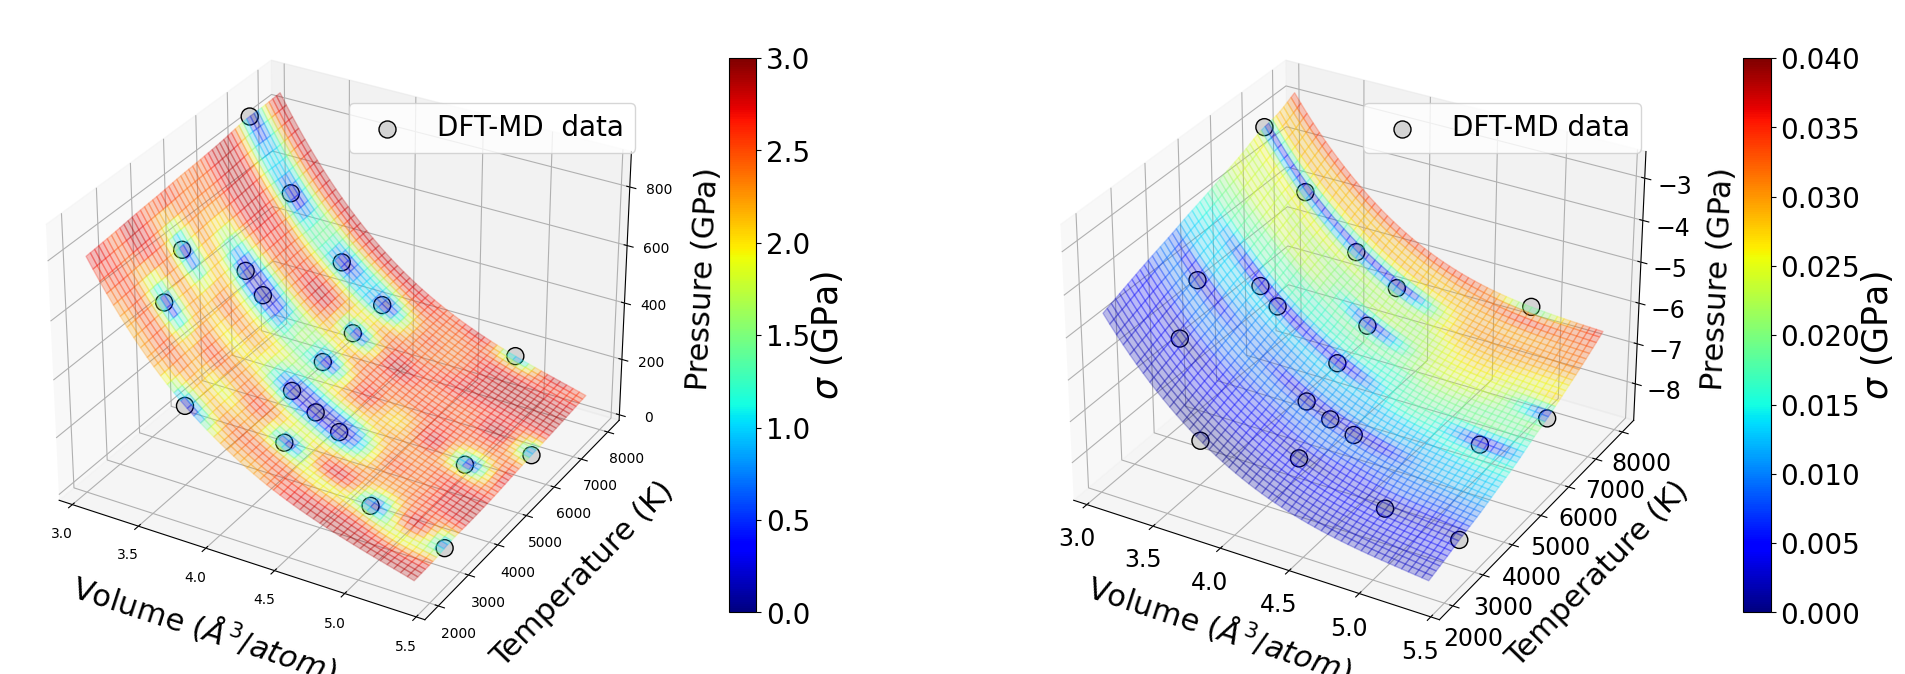

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize

fig = plt.figure(figsize=(24, 12))


ax1 = fig.add_subplot(121, projection='3d')
norm1 = Normalize(vmin=0, vmax=3)                   
colors1 = cm.jet(norm1(y_stdP.reshape(n_test, n_test)))
matplotlib.rc('xtick', labelsize=17)
matplotlib.rc('ytick', labelsize=17)

surf1 = ax1.plot_surface(x_testP[:, 0].reshape(n_test, n_test), x_testP[:, 1].reshape(n_test, n_test), y_meanP.reshape(n_test, n_test), facecolors=colors1, alpha=0.25, antialiased=True, rcount=100, ccount=100, shade=False)
data1 = ax1.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=1, s=150, color='lightgray', edgecolors='black', marker="o")

ax1.set_zlabel(r'Pressure (GPa)', fontsize=22, labelpad=14)
ax1.set_xlabel(r'Volume ($\AA^{3}/atom$)', fontsize=22, labelpad=14)
ax1.set_ylabel(r'Temperature (K)', fontsize=22, labelpad=17)
ax1.tick_params(axis='y', which='major', pad=5) 
ax1.tick_params(axis='z', which='major', pad=5) 

cbar1 = fig.colorbar(cm.ScalarMappable(norm=norm1, cmap=cm.jet), ax=ax1, shrink=0.6, pad=0.08)
cbar1.set_label(r'$\sigma\ (\mathrm{GPa})$', rotation=90, fontsize=25, labelpad=-1)
cbar1.ax.tick_params(labelsize=20)

ax1.legend([data1], ['DFT-MD  data'], loc=(0.52, 0.78), fontsize=20)
ax1.grid()


ax2 = fig.add_subplot(122, projection='3d')
norm2 = Normalize(vmin=0, vmax=0.04)
colors2 = cm.jet(norm2(y_stdE.reshape(n_test, n_test)))

surf2 = ax2.plot_surface(x_testE[:, 0].reshape(n_test, n_test), x_testE[:, 1].reshape(n_test, n_test), y_meanE.reshape(n_test, n_test), facecolors=colors2, alpha=0.25, antialiased=True, rcount=100, ccount=100, shade=False)
data2 = ax2.scatter(data[:, 0], data[:, 1], data[:, 3], alpha=1, s=150, color='lightgray', edgecolors='black', marker="o")

ax2.set_zlabel(r'Pressure (GPa)', fontsize=22, labelpad=14)
ax2.set_xlabel(r'Volume ($\AA^{3}/atom$)', fontsize=22, labelpad=14)
ax2.set_ylabel(r'Temperature (K)', fontsize=22, labelpad=17)
ax2.tick_params(axis='y', which='major', pad=5) 
ax2.tick_params(axis='z', which='major', pad=5) 

cbar2 = fig.colorbar(cm.ScalarMappable(norm=norm2, cmap=cm.jet), ax=ax2, shrink=0.6, pad=0.08)
cbar2.set_label(r'$\sigma\ (\mathrm{GPa})$', rotation=90, fontsize=25, labelpad=-1)
cbar2.ax.tick_params(labelsize=20)

ax2.legend([data2], ['DFT-MD data'], loc=(0.52, 0.78), fontsize=20)
ax2.grid()

plt.show()


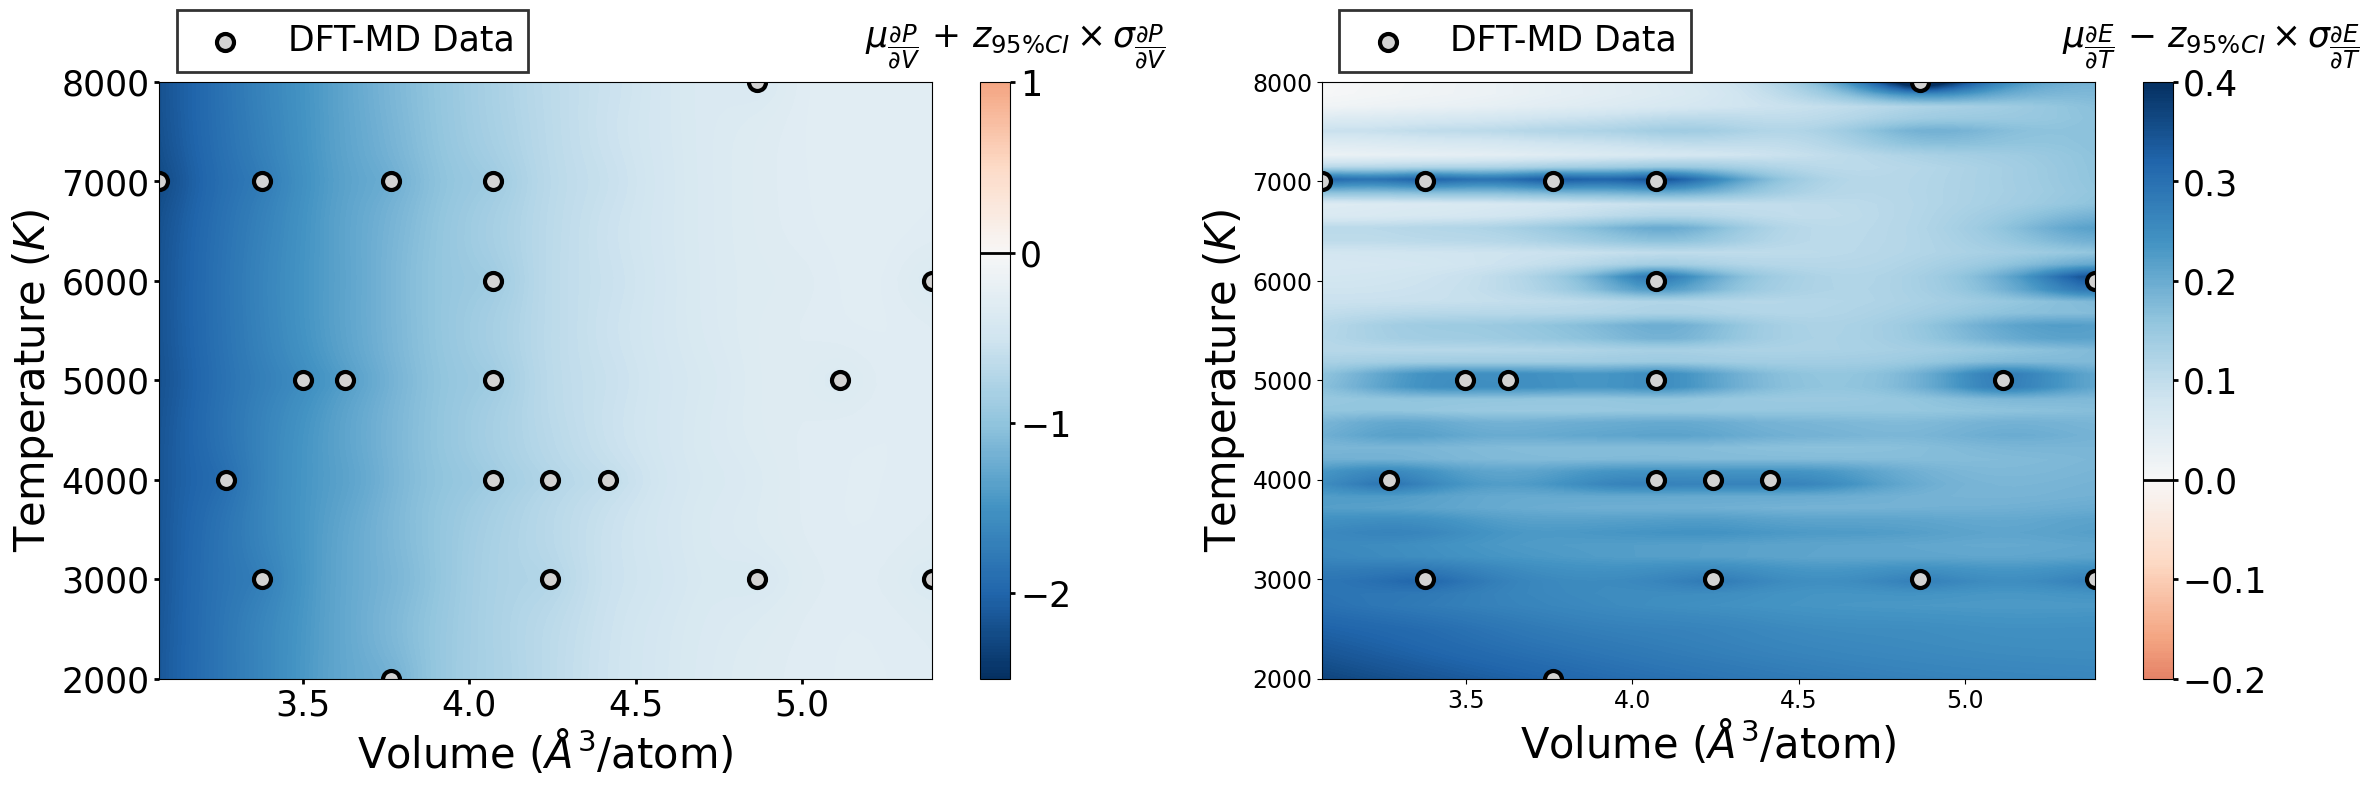

In [12]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

# Assuming x, y, consP, consE, and data are already defined as per your initial code

x = x_testP[:, 0].reshape((n_test, n_test))[0, :]
y = x_testP[:, 1].reshape((n_test, n_test))[:, 0]

norm1 = colors.Normalize(vmin=-2.5, vmax=1)
norm2 = MidpointNormalize(vmin=-0.2, vmax=0.4, midpoint=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

CS1 = ax1.contourf(x, y, consP.reshape((n_test, n_test)), 500, cmap=plt.cm.RdBu_r, norm=norm1)
ax1.scatter(data[:, 0], data[:, 1], alpha=1,  color='lightgray', edgecolors='black', marker="o", linewidths=3, s=150, label="DFT-MD Data")
ax1.set_ylabel(r'Temperature $(K)$', fontsize=30)
ax1.set_xlabel(r'Volume $(\AA^3$/atom)', fontsize=30)
ax1.tick_params(labelsize=25, colors='black', width=2)

legend1 = ax1.legend(loc='upper right', fontsize=25, bbox_to_anchor=(0.5, 1.15), fancybox=False)
legend1.get_frame().set_edgecolor("black")
legend1.get_frame().set_linewidth(2)

m1 = plt.cm.ScalarMappable(cmap=plt.cm.RdBu_r, norm=norm1)
cbar1 = plt.colorbar(m1, ax=ax1, boundaries=np.linspace(-2.5, 1, 200), ticks=[-2, -1, 0, 1])
cbar1.set_label(r'$\mu_{\dfrac{\partial P}{\partial V}}$ $+$ $z_{95\% CI} \times \sigma_{\dfrac{\partial P}{\partial V}}$', fontsize=25, labelpad=-40, rotation=0, y=1.1)
cbar1.ax.tick_params(axis='y', labelsize=25, colors='black', width=2)
cbar1.ax.axhline(0, color='black', linewidth=2)
m1.set_clim(-2.5, 2.5)


CS2 = ax2.contour(x, y, consE.reshape((n_test, n_test)).T, levels=[0], colors='k')
CS3 = ax2.contourf(x, y, consE.reshape((n_test, n_test)).T, 500, cmap=plt.cm.RdBu, norm=norm2)
ax2.clabel(CS2, inline=True, fontsize=20)
ax2.scatter(data[:, 0], data[:, 1], alpha=1, color='lightgray', edgecolors='black', marker="o", linewidths=3, s=150, label="DFT-MD Data")
ax2.set_ylabel(r'Temperature $(K)$', fontsize=30)
ax2.set_xlabel(r'Volume $(\AA^3$/atom)', fontsize=30)

legend2 = ax2.legend(loc='upper right', fontsize=25, bbox_to_anchor=(0.5, 1.15), fancybox=False)
legend2.get_frame().set_edgecolor("black")
legend2.get_frame().set_linewidth(2)

m2 = plt.cm.ScalarMappable(cmap=plt.cm.RdBu, norm=norm2)
cbar2 = plt.colorbar(m2, ax=ax2)
cbar2.set_label(r'$\mu_{\dfrac{\partial E}{\partial T}}$ $-$ $z_{95\% CI} \times \sigma_{\dfrac{\partial E}{\partial T}}$', fontsize=25, labelpad=-40, rotation=0, y=1.1)
cbar2.ax.tick_params(axis='y', labelsize=25, colors='black', width=2)
cbar2.ax.axhline(0, color='black', linewidth=2)

plt.tight_layout()
plt.show()


## Hugoniot computations

In [13]:
# Hugoniot points are obtained from the Eq. (36) of the paper using fine mesh. These are used to plot the bounds of the Hugoniot curves.
         
hp_fine = np.load('Hugoniot_points1.npy')   
 

In [14]:
# Hugoniot points are obtained from the Eq. (36) of the paper using (100 X 100) mesh.

hp_100 = np.load('Hugoniot_points2.npy')  

In [15]:
H_cond_ub = np.logical_and(1.8*hp_fine[:,3] <= hp_fine[:,2], hp_fine[:,2] <= 1.96*hp_fine[:,3])
H_cond_lb = np.logical_and(-1.96*hp_fine[:,3] <= hp_fine[:,2], hp_fine[:,2] <= -1.8*hp_fine[:,3])
hugo_ub = hp_fine[H_cond_ub]
hugo_lb = hp_fine[H_cond_lb]
ind1 = np.argsort(hugo_ub[:,0])
H_upper = hugo_ub[ind1]
ind2 = np.argsort(hugo_lb[:,0])
H_lower = hugo_lb[ind2]

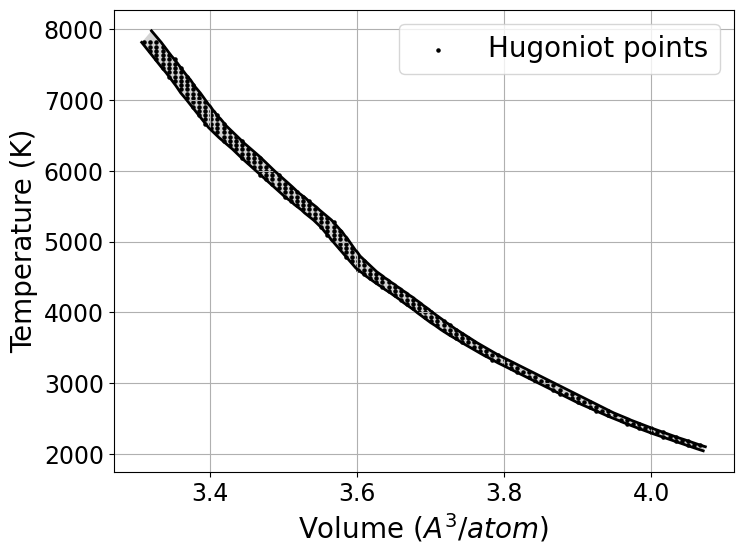

In [16]:
fig = plt.figure(figsize=(8,6))
plt.plot(H_upper[:,0], H_upper[:,1], color = 'k', linewidth = 2)
plt.plot(H_lower[:,0], H_lower[:,1], linewidth = 2, color ='k')
plt.fill(np.append(H_upper[:,0], H_lower[:,0][::-1]), np.append(H_upper[:,1], H_lower[:,1][::-1]), 'lightgrey')
p = plt.scatter(hp_100[6:287,0], hp_100[6:287,1], color = 'k',s = 5, label='Hugoniot points')
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
plt.xlabel(r'Volume ($A^{3}/atom$)', fontsize=20 )
plt.ylabel('Temperature (K)', fontsize=20)
plt.legend([p],['Hugoniot points'], loc='upper right', fontsize =20)
plt.grid()

In [17]:
x_H = np.hstack((hp_100[:,0].reshape(-1,1), hp_100[:,1].reshape(-1,1)))
x_H = scaler_X.transform(x_H)

In [18]:
hugo_pred, hugo_var = gp.predict(x_H, x_H)

In [19]:
hugo11 = hugo_pred[:x_H.shape[0]].reshape(-1,1)
hugo22 = np.sqrt(hugo_var[:x_H.shape[0]]).reshape(-1,1)

In [20]:
hugo_meanP = scaler_y1.inverse_transform(hugo11)
hugo_ubP =  scaler_y1.inverse_transform(hugo11+hugo22)
hugo_stdP = hugo_ubP - hugo_meanP

In [21]:
X_H = scaler_X.inverse_transform(x_H)

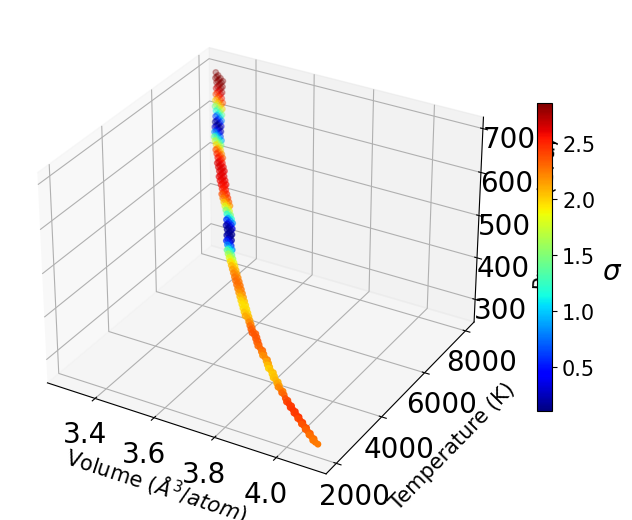

In [22]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
p0 = ax.scatter(X_H[:,0], X_H[:,1], hugo_meanP ,c= hugo_stdP, cmap=plt.cm.jet, s=15)
ax.set_yticks([2000,4000,6000,8000])
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
ax.set_xlabel(r'Volume ($\AA^{3}/atom$)', fontsize=15, labelpad=8 )
ax.set_ylabel('Temperature (K)', fontsize=15, labelpad=12)
ax.set_zlabel('Pressure (GPa)',fontsize=15, labelpad=9)
cbar = fig.colorbar(p0, ax=ax, shrink = 0.5)
cbar.set_label(r'$\sigma$', rotation=0, fontsize=20, labelpad= 12)
plt.show()


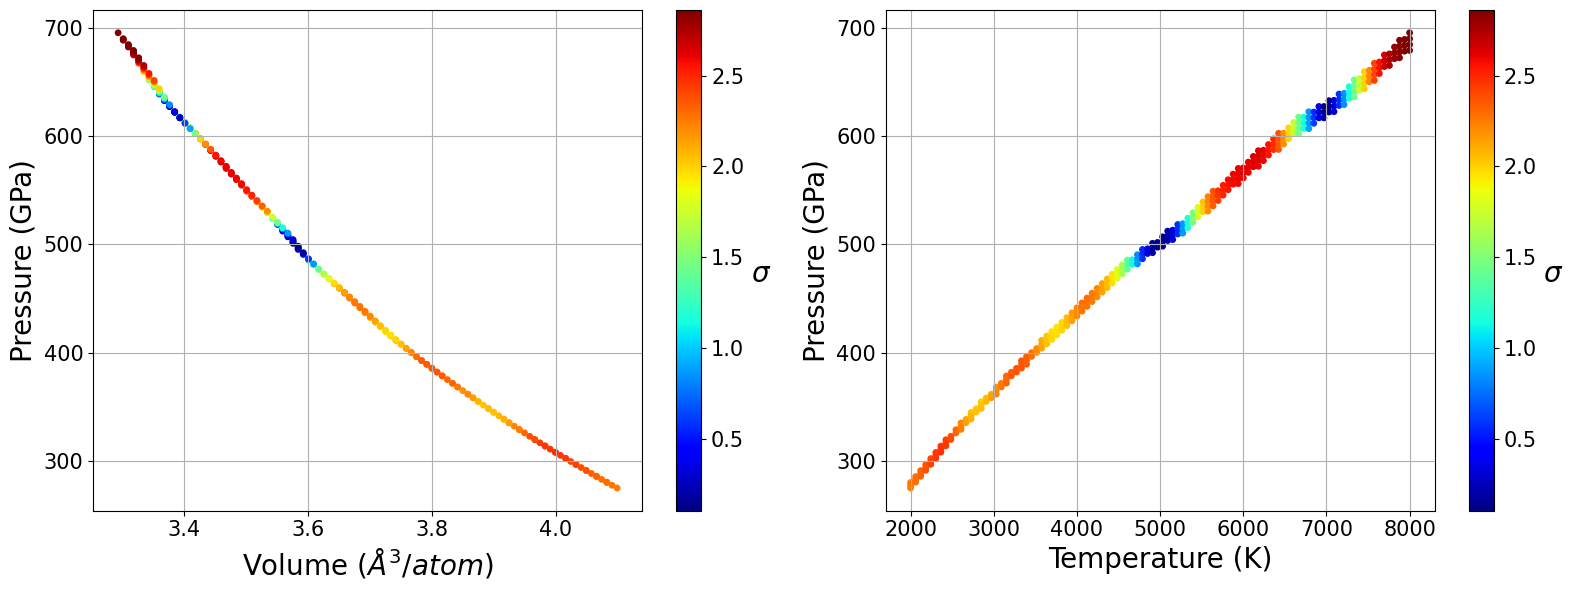

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

p0 = ax1.scatter(X_H[:,0], hugo_meanP, c=hugo_stdP, cmap=plt.cm.jet, s=15)
ax1.set_xlabel(r'Volume ($\AA^{3}/atom$)', fontsize=20)
ax1.set_ylabel('Pressure (GPa)', fontsize=20)
ax1.tick_params(axis='both', labelsize=15)
cbar = fig.colorbar(p0, ax=ax1, shrink=1)
cbar.set_label(r'$\sigma$', rotation=0, fontsize=20, labelpad=12)
ax1.grid()

p1 = ax2.scatter(X_H[:,1], hugo_meanP, c=hugo_stdP, cmap=plt.cm.jet, s=15)
ax2.set_xlabel('Temperature (K)', fontsize=20)
ax2.set_ylabel('Pressure (GPa)', fontsize=20)
ax2.tick_params(axis='both', labelsize=15)
cbar = fig.colorbar(p1, ax=ax2, shrink=1)
cbar.set_label(r'$\sigma$', rotation=0, fontsize=20, labelpad=12)
ax2.grid()

plt.tight_layout() 
plt.show()


## Unified GP EOS model

We use regression to fit Hugoniot points to a fourth-degree polynomial and estimate the temperature at specified volumes. Typically, Hugoniot experimental data is presented in the form of (V, P). By estimating temperature for given volumes, we generate data in the form of pressure \(P\) corresponding to \((V, T)\). This experimental dataset is combined with EOS data from DFT-MD simulations allowing us to train a unified GP model for the EOS.

In [24]:
poly = PolynomialFeatures(degree=4)
a = (1/12.011)*6.023*0.1    # for converting units
v = np.array([4.74, 5.77, 5.0])   # experimental volumes Ref. [32] 
V_exp = (v*a)**(-1)
poly_train = poly.fit_transform(hp_100[:,0].reshape(-1,1))
reg = LinearRegression().fit(poly_train, hp_100[:,1])
exptestV = poly.fit_transform(V_exp.reshape(-1,1))
T_exp = reg.predict(exptestV) 

In [25]:
print('Volume from experimental Hugoniot data', V_exp)
print('Estimated temperatures', T_exp)


Volume from experimental Hugoniot data [4.20714967 3.45613335 3.98837788]
Estimated temperatures [1677.4818324  6191.47299911 2373.53608845]


In [26]:
# Combine experimental and DFT-MD data for training the unified GP model

X_exp = np.hstack((V_exp.reshape(-1,1), T_exp.reshape(-1,1)))
y_exp = np.array([265, 599, 316]).reshape(-1,1)  # experimental pressure data Ref. [32]
X1 = np.vstack((data[:,0:2], X_exp))
X2 = data[:,0:2]
y1 = np.vstack((data[:,2].reshape(-1,1), y_exp))    # pressure
y2 = data[:,3].reshape(-1,1)       

In [27]:
scaler_X_unified = MinMaxScaler()
scaler_X_unified.fit(X1)
X_scaled1 = scaler_X_unified.transform(X1)
X_scaled2 = scaler_X_unified.transform(X2)

scaler_y1_unified = MinMaxScaler()
y1_scaled = scaler_y1_unified.fit_transform(y1)
scaler_y2_unified = MinMaxScaler()
y2_scaled = scaler_y2_unified.fit_transform(y2)

In [28]:
optimal_hyperparameters = gp.fit(X_scaled1, X_scaled2, y1_scaled, y2_scaled)

0

   Normal return from subroutine COBYLA

   NFVALS =  104   F =-1.782328E+02    MAXCV = 0.000000E+00
   X =-9.778412E-01  -1.178861E+00  -3.286234E+00  -9.272652E+00  -1.097858E+01
1

   Normal return from subroutine COBYLA

   NFVALS =  125   F =-1.782328E+02    MAXCV = 0.000000E+00
   X =-9.779466E-01  -1.178847E+00  -3.286207E+00  -1.140323E+01  -1.128490E+01
2

   Normal return from subroutine COBYLA

   NFVALS =  115   F =-1.782328E+02    MAXCV = 0.000000E+00
   X =-9.778332E-01  -1.178841E+00  -3.286195E+00  -7.613631E+00  -8.735210E+00
3

   Normal return from subroutine COBYLA

   NFVALS =  324   F =-1.782328E+02    MAXCV = 0.000000E+00
   X =-9.777660E-01  -1.178741E+00  -3.285998E+00  -1.085732E+01  -1.286321E+01
4

   Normal return from subroutine COBYLA

   NFVALS =  115   F =-1.782328E+02    MAXCV = 0.000000E+00
   X =-9.779605E-01  -1.178917E+00  -3.286346E+00  -8.364274E+00  -9.872587E+00
5

   Normal return from subroutine COBYLA

   NFVALS =   88   F =-1.782328E+02 

In [29]:
y_pred_unified, y_var_unified = gp.predict(x_test1, x_test2)

In [30]:
y11 = y_pred_unified[:x_test1.shape[0]].reshape(-1,1)
y22 = y_pred_unified[x_test1.shape[0]:].reshape(-1,1)
y33 = np.sqrt(y_var_unified[:x_test1.shape[0]]).reshape(-1,1)
y44 = np.sqrt(y_var_unified[x_test1.shape[0]:]).reshape(-1,1)

y_meanP_unified = scaler_y1_unified.inverse_transform(y11)
y_meanE_unified = scaler_y2_unified.inverse_transform(y22)
y_ubP = scaler_y1_unified.inverse_transform(y11+y33)
y_ubE = scaler_y2_unified.inverse_transform(y22+y44)
y_stdP_unified = y_ubP - y_meanP_unified
y_stdE_unified = y_ubE - y_meanE_unified
X_testP = scaler_X_unified.inverse_transform(x_test1)
X_testE = scaler_X_unified.inverse_transform(x_test2)

In [31]:

y_pred_prime_unified, y_varr_prime_unified = gp.predict_prime(gp.theta, x_test1, x_test2)
consP_unified = y_pred_prime_unified[:x_test1.shape[0]] + 1.96*np.sqrt(y_varr_prime_unified[:x_test1.shape[0]])   
consE_unified = y_pred_prime_unified[x_test1.shape[0]:] - 1.96*np.sqrt(y_varr_prime_unified[x_test1.shape[0]:])   

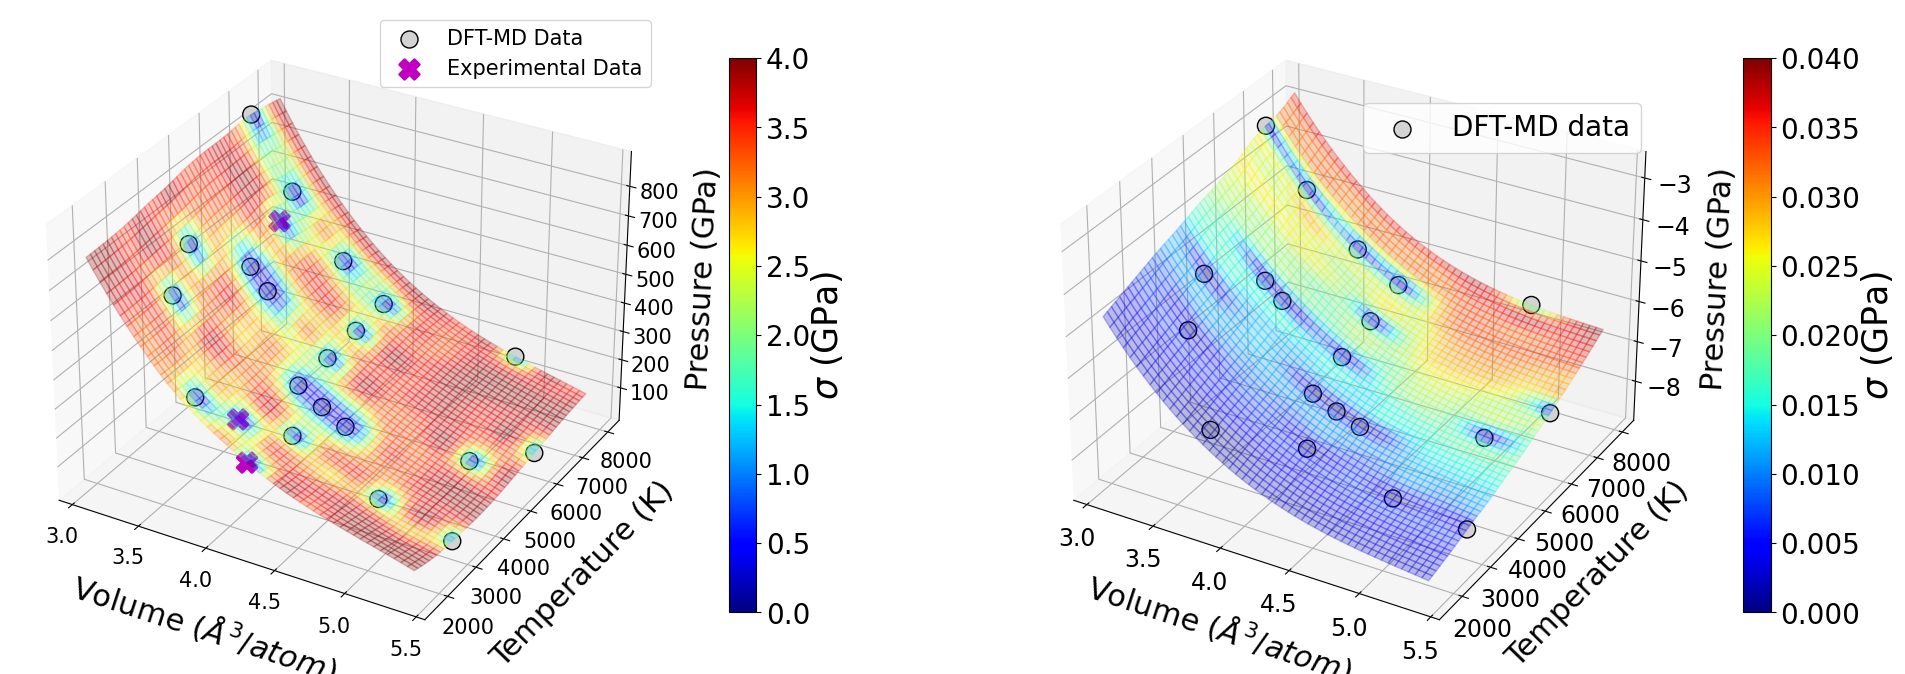

In [32]:
fig = plt.figure(figsize=(24, 12))

ax1 = fig.add_subplot(121, projection='3d')

norm1 = Normalize(vmin=0, vmax=4)
colors1 = cm.jet(norm1(y_stdP_unified.reshape(n_test, n_test)))
matplotlib.rc('xtick', labelsize=17)
matplotlib.rc('ytick', labelsize=17)

surf1 = ax1.plot_surface(X_testP[:, 0].reshape(n_test, n_test), X_testP[:, 1].reshape(n_test, n_test), y_meanP_unified.reshape(n_test, n_test), facecolors=colors1, alpha=0.25, antialiased=True, rcount=100, ccount=100, shade=False)
data1 = ax1.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=1, s=150, color='lightgray', edgecolors='black', marker="o")
exp_data1 = ax1.scatter(X_exp[:, 0], X_exp[:, 1], y_exp, alpha=1, marker="X", color="m", s=200, linewidths=2, label="Experimental Data")

ax1.set_zlabel(r'Pressure (GPa)', fontsize=22, labelpad=14)
ax1.set_xlabel(r'Volume ($\AA^{3}/atom$)', fontsize=22, labelpad=14)
ax1.set_ylabel(r'Temperature (K)', fontsize=22, labelpad=17)
ax1.tick_params(axis='y', which='major', pad=5) 
ax1.tick_params(axis='z', which='major', pad=5) 

cbar1 = fig.colorbar(cm.ScalarMappable(norm=norm1, cmap=cm.jet), ax=ax1, shrink=0.6, pad=0.08)
cbar1.set_label(r'$\sigma\ (\mathrm{GPa})$', rotation=90, fontsize=25, labelpad=-1)
cbar1.ax.tick_params(labelsize=20)

# ax1.legend([data1], ['Training data'], loc=(0.52, 0.78), fontsize=20)
ax1.legend([data1, exp_data1],['DFT-MD Data', 'Experimental Data'], loc='upper right', fontsize=15)
ax1.grid()

# Second subplot
ax2 = fig.add_subplot(122, projection='3d')

norm2 = Normalize(vmin=0, vmax=0.04)
colors2 = cm.jet(norm2(y_stdE_unified.reshape(n_test, n_test)))

surf2 = ax2.plot_surface(X_testE[:, 0].reshape(n_test, n_test), X_testE[:, 1].reshape(n_test, n_test), y_meanE_unified.reshape(n_test, n_test), facecolors=colors2, alpha=0.25, antialiased=True, rcount=100, ccount=100, shade=False)
data2 = ax2.scatter(data[:, 0], data[:, 1], data[:, 3], alpha=1, s=150, color='lightgray', edgecolors='black', marker="o")

ax2.set_zlabel(r'Pressure (GPa)', fontsize=22, labelpad=14)
ax2.set_xlabel(r'Volume ($\AA^{3}/atom$)', fontsize=22, labelpad=14)
ax2.set_ylabel(r'Temperature (K)', fontsize=22, labelpad=17)
ax2.tick_params(axis='y', which='major', pad=5) 
ax2.tick_params(axis='z', which='major', pad=5) 

cbar2 = fig.colorbar(cm.ScalarMappable(norm=norm2, cmap=cm.jet), ax=ax2, shrink=0.6, pad=0.08)
cbar2.set_label(r'$\sigma\ (\mathrm{GPa})$', rotation=90, fontsize=25, labelpad=-1)
cbar2.ax.tick_params(labelsize=20)

ax2.legend([data2], ['DFT-MD data'], loc=(0.52, 0.78), fontsize=20)
ax2.grid()

plt.show()


/var/folders/vd/pr68_4js7vnf535141p_blwc0000gn/T/ipykernel_23041/375769374.py:40: UserWarning: No contour levels were found within the data range.
  CS2 = ax2.contour(x, y, consE_unified.reshape((n_test, n_test)).T, levels=[0], colors='k')


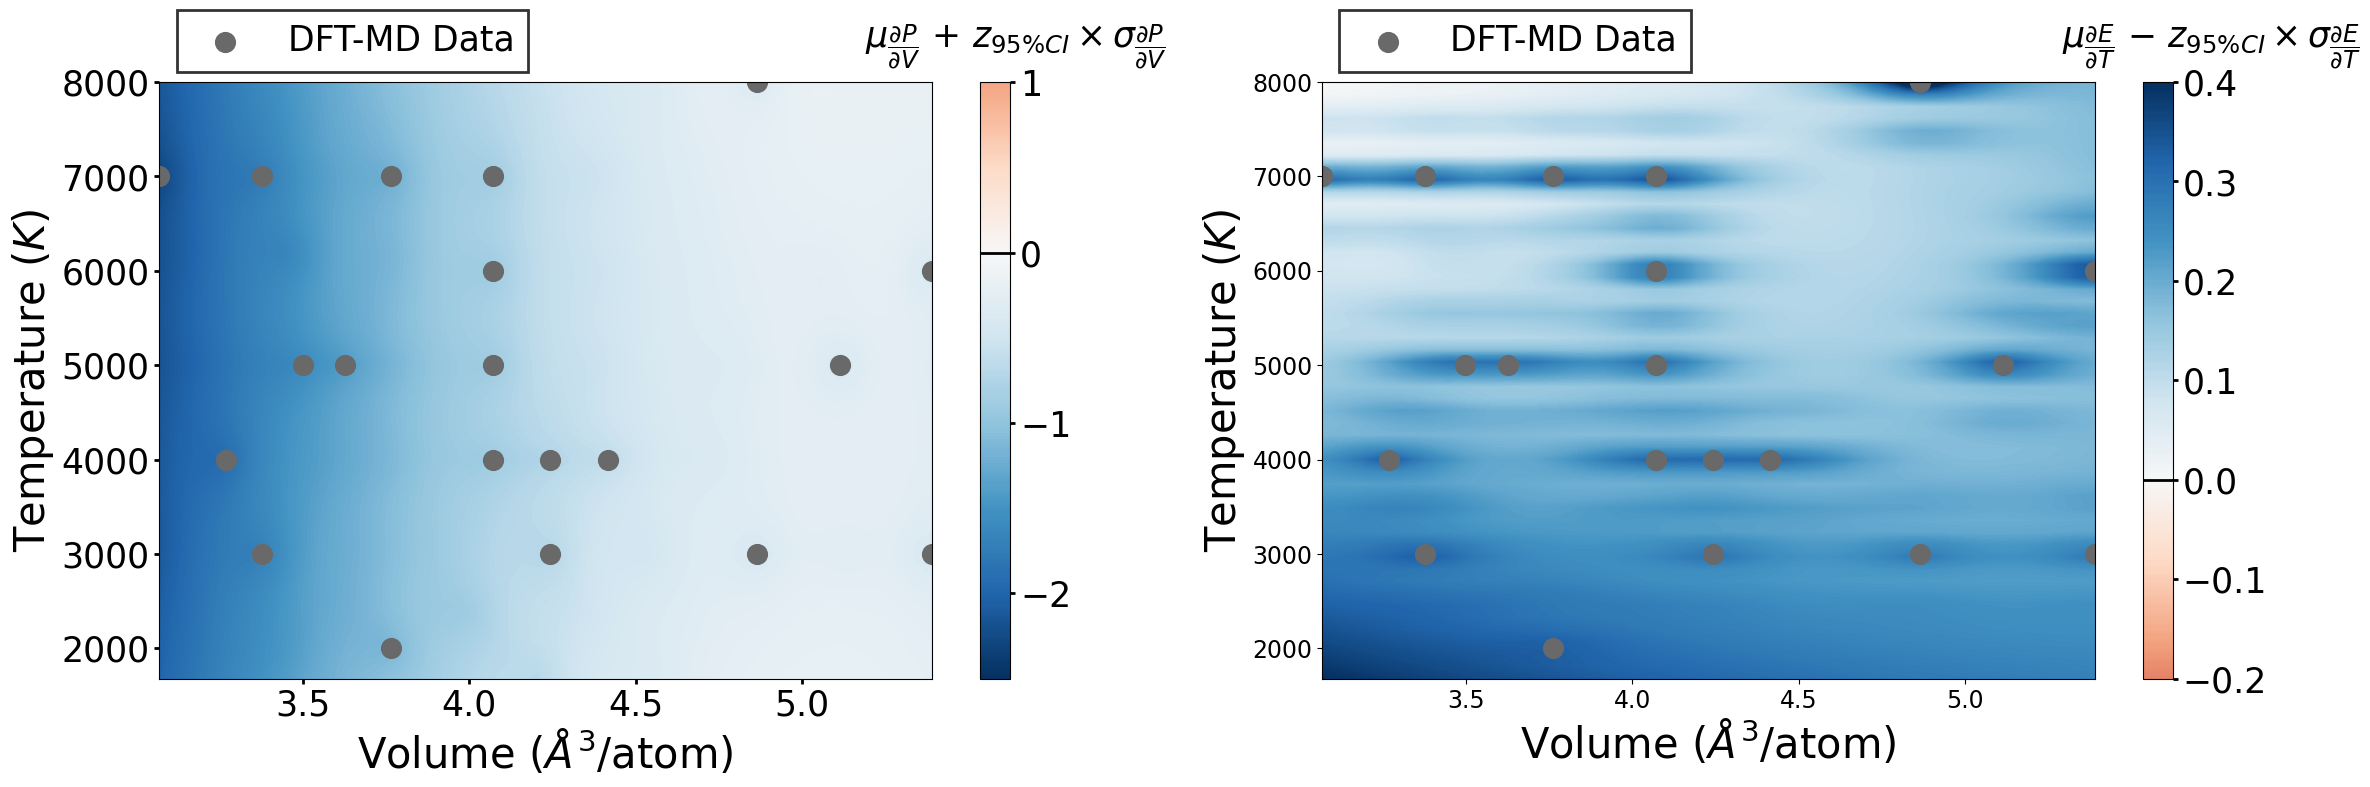

In [33]:

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

x = X_testP[:, 0].reshape((n_test, n_test))[0, :]
y = X_testP[:, 1].reshape((n_test, n_test))[:, 0]

norm1 = colors.Normalize(vmin=-2.5, vmax=1)
norm2 = MidpointNormalize(vmin=-0.2, vmax=0.4, midpoint=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))


CS1 = ax1.contourf(x, y, consP_unified.reshape((n_test, n_test)), 500, cmap=plt.cm.RdBu_r, norm=norm1)
ax1.scatter(data[:, 0], data[:, 1], alpha=1, color='dimgrey', marker="o", linewidths=3, s=150, label="DFT-MD Data")
ax1.set_ylabel(r'Temperature $(K)$', fontsize=30)
ax1.set_xlabel(r'Volume $(\AA^3$/atom)', fontsize=30)
ax1.tick_params(labelsize=25, colors='black', width=2)

legend1 = ax1.legend(loc='upper right', fontsize=25, bbox_to_anchor=(0.5, 1.15), fancybox=False)
legend1.get_frame().set_edgecolor("black")
legend1.get_frame().set_linewidth(2)

m1 = plt.cm.ScalarMappable(cmap=plt.cm.RdBu_r, norm=norm1)
cbar1 = plt.colorbar(m1, ax=ax1, boundaries=np.linspace(-2.5, 1, 200), ticks=[-2, -1, 0, 1])
cbar1.set_label(r'$\mu_{\dfrac{\partial P}{\partial V}}$ $+$ $z_{95\% CI} \times \sigma_{\dfrac{\partial P}{\partial V}}$', fontsize=25, labelpad=-40, rotation=0, y=1.1)
cbar1.ax.tick_params(axis='y', labelsize=25, colors='black', width=2)
cbar1.ax.axhline(0, color='black', linewidth=2)
m1.set_clim(-2.5, 2.5)


CS2 = ax2.contour(x, y, consE_unified.reshape((n_test, n_test)).T, levels=[0], colors='k')
CS3 = ax2.contourf(x, y, consE_unified.reshape((n_test, n_test)).T, 500, cmap=plt.cm.RdBu, norm=norm2)
ax2.clabel(CS2, inline=True, fontsize=20)
ax2.scatter(data[:, 0], data[:, 1], alpha=1, color='dimgrey', marker="o", linewidths=3, s=150, label="DFT-MD Data")
ax2.set_ylabel(r'Temperature $(K)$', fontsize=30)
ax2.set_xlabel(r'Volume $(\AA^3$/atom)', fontsize=30)

legend2 = ax2.legend(loc='upper right', fontsize=25, bbox_to_anchor=(0.5, 1.15), fancybox=False)
legend2.get_frame().set_edgecolor("black")
legend2.get_frame().set_linewidth(2)

m2 = plt.cm.ScalarMappable(cmap=plt.cm.RdBu, norm=norm2)
cbar2 = plt.colorbar(m2, ax=ax2)
cbar2.set_label(r'$\mu_{\dfrac{\partial E}{\partial T}}$ $-$ $z_{95\% CI} \times \sigma_{\dfrac{\partial E}{\partial T}}$', fontsize=25, labelpad=-40, rotation=0, y=1.1)
cbar2.ax.tick_params(axis='y', labelsize=25, colors='black', width=2)
cbar2.ax.axhline(0, color='black', linewidth=2)

plt.tight_layout()
plt.show()


